# Tech Challenge - Fase 3

Grupo 14

João Luiz Pereira de Freitas – RM 358102

Taiany Soares Ribeiro Giacomeli – RM 358555

# Carregamento dos dados do GCP utilizando o Pandas e o Spark

Utilizaremos os microdados dos meses de setembro, outubro e novembro de 2020, disponíveis no link: https://www.ibge.gov.br/estatisticas/downloads-estatisticas.html?caminho=Trabalho_e_Rendimento/Pesquisa_Nacional_por_Amostra_de_Domicilios_PNAD_COVID19/Microdados/Dados

Esses dados foram carregados para o Cloud Storage do GCP

In [ ]:
# Instalando as bibliotecas

!pip install pyspark

In [ ]:
!pip install findspark

In [ ]:
!pip install google-cloud-storage

In [ ]:
# Aqui é necessário fazer o upload da chave.json que foi disponibilizada no arquivo .zip

import findspark
import os
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/chave.json"

In [ ]:
# Testando o spark

df = spark.sql('''select 'Sucesso total, estamos online!' as hello''')
df.show()

+--------------------+
|               hello|
+--------------------+
|Sucesso total, es...|
+--------------------+



In [ ]:
# importando as funções do spark e demais bibliotecas

from pyspark.sql import Row, DataFrame
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import col, expr, lit, substring, concat, concat_ws, when, coalesce, countDistinct
from pyspark.sql import functions as F
from functools import reduce
import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import storage
from io import StringIO

In [ ]:
# Realizando a conexão com o bucket dentro do google storage, e verificando os arquivos disponíveis

bucket_name = 'tech-challenge-fiap-fase-3'
client = storage.Client()
bucket = client.get_bucket(bucket_name)
blobs = bucket.list_blobs()

for blob in blobs:
  print(blob.name)

PNAD_COVID_092020.csv
PNAD_COVID_102020.csv
PNAD_COVID_112020.csv


In [ ]:
# Carregando os arquivos com o pandas

file_path_set = "PNAD_COVID_092020.csv"
blob_set = bucket.blob(file_path_set)
csv_data_set = blob_set.download_as_text()

file_path_out = "PNAD_COVID_102020.csv"
blob_out = bucket.blob(file_path_out)
csv_data_out = blob_out.download_as_text()

file_path_nov = "PNAD_COVID_112020.csv"
blob_nov = bucket.blob(file_path_nov)
csv_data_nov = blob_nov.download_as_text()

df_set = pd.read_csv(StringIO(csv_data_set))
print(df_set.shape)

df_out = pd.read_csv(StringIO(csv_data_out))
print(df_out.shape)

df_nov = pd.read_csv(StringIO(csv_data_nov))
print(df_nov.shape)

(387298, 145)
(380461, 145)
(381438, 148)


In [ ]:
# Transformando os dataframes do pandas em arquivos csv

df_set.to_csv('dados_set.csv', index=False)
df_out.to_csv('dados_out.csv', index=False)
df_nov.to_csv('dados_nov.csv', index=False)

In [ ]:
# Trazendo os dados para o spark

df_set = spark.read.csv('/content/dados_set.csv', sep = ',', inferSchema=True, header=True)
df_out = spark.read.csv('/content/dados_out.csv', sep = ',', inferSchema=True, header=True)
df_nov = spark.read.csv('/content/dados_nov.csv', sep = ',', inferSchema=True, header=True)

print('Número de registros - Setembro :', df_set.count())
print('Número de colunas - Setembro   :', len(df_set.columns))
print()
print('Número de registros - Outubro  :', df_out.count())
print('Número de colunas - Outubro    :', len(df_out.columns))
print()
print('Número de registros - Novembro :', df_nov.count())
print('Número de colunas - Novembro   :', len(df_nov.columns))

Número de registros - Setembro : 387298
Número de colunas - Setembro   : 145

Número de registros - Outubro  : 380461
Número de colunas - Outubro    : 145

Número de registros - Novembro : 381438
Número de colunas - Novembro   : 148


Cada mês conta com aproximadamente 380 mil registros, e existe uma variação no número de colunas, então após criar cada um dos dataframes, vamos avaliar a melhor maneira de fazer a união das bases.

In [ ]:
# Criando o dataframe de Setembro

df_set.createOrReplaceTempView('covid_set')
df_set.show()

+----+---+-------+-------+-----+-----+-----+-----+-------+---------+-----+-----+------+------------+------------+------+----+-----+------+------+------+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+----+----+----+----+-----+-----+-----+----+----+-----+-----+-----+-----+-----+------+------+-----+----+----+-----+----+-----+------+------+-----+------+------+-----+-----+-----+------+-------+-------+------+-------+-------+----+----+----+----+----+-----+-----+------+-----+-----+-----+-----+-----+------+-----+------+-----+-----+-----+-----+----+-----+-----+-----+-----+----+-----+-----+------+------+------+------+------+-----+----+
| Ano| UF|CAPITAL|RM_RIDE|V1008|V1012|V1013|V1016|Estrato|      UPA|V1022|V1023| V1030|       V1031|       

In [ ]:
# Criando o dataframe de Outubro

df_out.createOrReplaceTempView('covid_out')
df_out.show()

+----+---+-------+-------+-----+-----+-----+-----+-------+---------+-----+-----+------+------------+------------+------+----+-----+------+------+------+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+----+----+----+----+-----+-----+-----+----+----+-----+-----+-----+-----+-----+------+------+-----+----+----+-----+----+-----+------+------+-----+------+------+-----+-----+-----+------+-------+-------+------+-------+-------+----+----+----+----+----+-----+-----+------+-----+-----+-----+-----+-----+------+-----+------+-----+-----+-----+-----+----+-----+-----+-----+-----+----+-----+-----+------+------+------+------+------+-----+----+
| Ano| UF|CAPITAL|RM_RIDE|V1008|V1012|V1013|V1016|Estrato|      UPA|V1022|V1023| V1030|       V1031|       

In [ ]:
# Criando o dataframe de Novembro

df_nov.createOrReplaceTempView('covid_nov')
df_nov.show()

+----+---+-------+-------+-----+-----+-----+-----+-------+---------+-----+-----+------+------------+------------+------+----+-----+------+------+------+----+----+----+----+----+-----+-----+----+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+----+----+----+----+-----+-----+-----+----+----+-----+-----+-----+-----+-----+------+------+-----+----+----+-----+----+-----+------+------+-----+------+------+-----+-----+-----+------+-------+-------+------+-------+-------+----+----+----+----+----+-----+-----+------+-----+-----+-----+-----+-----+------+-----+------+-----+-----+-----+-----+----+-----+-----+-----+-----+----+-----+-----+------+------+------+------+------+-----+----+
| Ano| UF|CAPITAL|RM_RIDE|V1008|V1012|V1013|V1016|Estrato|      UPA|V1022|V1023| V1030|  

Como podemos ver, temos várias colunas com nomes pouco usuais, como V1008, V1013..., e vamos precisar tratá-las. Vamos utilizar para isso os dicionários fornecidos pelo próprio IBGE, disponíveis no link: https://www.ibge.gov.br/estatisticas/downloads-estatisticas.html?caminho=Trabalho_e_Rendimento/Pesquisa_Nacional_por_Amostra_de_Domicilios_PNAD_COVID19/Microdados/Documentacao

# Tratamento dos dados

Nosso primeiro passo é separar as vinte questões da pesquisa com que vamos trabalhar, e as colunas que podemos usar para obter a resposta:

1 - Mês da Pesquisa (Coluna V1013)

2 - UF (Coluna UF)

3 - Situação do Domicilio (Coluna V1022)

4 - Idade (Coluna A002)

5 - Sexo (Coluna A003)

6 - Escolaridade (Coluna A005)

7 - Na semana passada teve febre? (Coluna B0011)

8 - Na semana passada teve tosse? (Coluna B0012)

9 - Na semana passada teve dor de garganta? (Coluna B0013)

10 - Na semana passada teve dificuldade para respirar? (Coluna B0014)

11 - Tem algum plano de saúde médico, seja particular, de empresa ou de órgão público? (Coluna B007)

12 - Na semana passada, por pelo menos uma hora, trabalhou ou fez algum bico? (Coluna C001)

13 - Número da faixa do rendimento/retirada em dinheiro (Coluna C01011)

14 - Na semana passada teve dor de cabeça? (Coluna B0015)

15 - Na semana passsada teve náusea? (Coluna B0017)

16 - Na semana passada teve nariz entupido ou escorrendo? (Coluna B0018)

17 - Na semana passada teve fadiga? (Coluna B0019)

18 - Na semana passada teve perda de cheiro ou sabor? (Coluna B00111)

19 - Na semana passada teve dor muscular? (Coluna B00112)

20 - Por causa disso, foi a algum estabelecimento de saúde? (Coluna B002)

In [ ]:
# Com essa seleção, já podemos reduzir o nosso dataframe para 20 colunas, além de deixar os dados de cada mês com as mesmas informações, possibilitanto a unificação

df_quest_set = spark.sql('''select V1013, UF, V1022, A002, A003, A005, B0011, B0012, B0013, B0014, B007, C001, C01011, B0015, B0017, B0018, B0019, B00111, B00112, B002 from covid_set''')
df_quest_set.show()

+-----+---+-----+----+----+----+-----+-----+-----+-----+----+----+------+-----+-----+-----+-----+------+------+----+
|V1013| UF|V1022|A002|A003|A005|B0011|B0012|B0013|B0014|B007|C001|C01011|B0015|B0017|B0018|B0019|B00111|B00112|B002|
+-----+---+-----+----+----+----+-----+-----+-----+-----+----+----+------+-----+-----+-----+-----+------+------+----+
|    9| 11|    1|  36|   1|   5|    2|    2|    2|    2|   1| 1.0|   4.0|    2|    2|    2|    2|     2|     2|NULL|
|    9| 11|    1|  30|   2|   7|    2|    2|    2|    2|   2| 1.0|   4.0|    2|    2|    2|    2|     2|     2|NULL|
|    9| 11|    1|  13|   1|   2|    2|    2|    2|    2|   1|NULL|  NULL|    2|    2|    2|    2|     2|     2|NULL|
|    9| 11|    1|  11|   1|   2|    2|    2|    2|    2|   1|NULL|  NULL|    2|    2|    2|    2|     2|     2|NULL|
|    9| 11|    1|  57|   2|   2|    2|    2|    2|    2|   2| 2.0|  NULL|    2|    2|    2|    2|     2|     2|NULL|
|    9| 11|    1|  58|   2|   1|    2|    2|    2|    2|   2| 1.

In [ ]:
df_quest_out = spark.sql('''select V1013, UF, V1022, A002, A003, A005, B0011, B0012, B0013, B0014, B007, C001, C01011, B0015, B0017, B0018, B0019, B00111, B00112, B002 from covid_out''')
df_quest_out.show()

+-----+---+-----+----+----+----+-----+-----+-----+-----+----+----+------+-----+-----+-----+-----+------+------+----+
|V1013| UF|V1022|A002|A003|A005|B0011|B0012|B0013|B0014|B007|C001|C01011|B0015|B0017|B0018|B0019|B00111|B00112|B002|
+-----+---+-----+----+----+----+-----+-----+-----+-----+----+----+------+-----+-----+-----+-----+------+------+----+
|   10| 11|    1|  36|   1|   5|    2|    2|    2|    2|   1| 1.0|   4.0|    2|    2|    2|    2|     2|     2|NULL|
|   10| 11|    1|  30|   2|   7|    2|    2|    2|    2|   2| 1.0|   4.0|    2|    2|    2|    2|     2|     2|NULL|
|   10| 11|    1|  13|   1|   2|    2|    2|    2|    2|   1|NULL|  NULL|    2|    2|    2|    2|     2|     2|NULL|
|   10| 11|    1|  11|   1|   2|    2|    2|    2|    2|   1|NULL|  NULL|    2|    2|    2|    2|     2|     2|NULL|
|   10| 11|    1|  57|   2|   2|    2|    2|    2|    2|   2| 2.0|  NULL|    2|    2|    2|    2|     2|     2|NULL|
|   10| 11|    1|  58|   2|   1|    2|    2|    2|    2|   2| 1.

In [ ]:
df_quest_nov = spark.sql('''select V1013, UF, V1022, A002, A003, A005, B0011, B0012, B0013, B0014, B007, C001, C01011, B0015, B0017, B0018, B0019, B00111, B00112, B002 from covid_nov''')
df_quest_nov.show()

+-----+---+-----+----+----+----+-----+-----+-----+-----+----+----+------+-----+-----+-----+-----+------+------+----+
|V1013| UF|V1022|A002|A003|A005|B0011|B0012|B0013|B0014|B007|C001|C01011|B0015|B0017|B0018|B0019|B00111|B00112|B002|
+-----+---+-----+----+----+----+-----+-----+-----+-----+----+----+------+-----+-----+-----+-----+------+------+----+
|   11| 11|    1|  36|   1|   5|    2|    2|    2|    2|   1| 1.0|   4.0|    2|    2|    2|    2|     2|     2|NULL|
|   11| 11|    1|  30|   2|   7|    2|    2|    2|    2|   2| 1.0|   4.0|    2|    2|    2|    2|     2|     2|NULL|
|   11| 11|    1|  13|   1|   2|    2|    2|    2|    2|   1|NULL|  NULL|    2|    2|    2|    2|     2|     2|NULL|
|   11| 11|    1|  11|   1|   2|    2|    2|    2|    2|   1|NULL|  NULL|    2|    2|    2|    2|     2|     2|NULL|
|   11| 11|    1|  57|   2|   2|    2|    2|    2|    2|   2| 2.0|  NULL|    2|    2|    2|    2|     2|     2|NULL|
|   11| 11|    1|  58|   2|   1|    2|    2|    2|    2|   2| 1.

In [ ]:
# Agora podemos fazer a unificação

df_quest_unificado = df_quest_set.union(df_quest_out).union(df_quest_nov)
print('Número de registros - Total:', df_quest_unificado.count())

Número de registros - Total: 1149197


Com os dados unificados, vamos trabalhar agora com a renomeação das colunas, e em seguida dos dados, para se tornarem mais legíveis

Renomeação das colunas:

Coluna V1013 = mes

Coluna UF = uf

Coluna V1022 = situacao_domicilio

Coluna A002 = idade

Coluna A003 = sexo

Coluna A005 = escolaridade

Coluna B0011 = febre

Coluna B0012 = tosse

Coluna B0013 = dor_garganta

Coluna B0014 = dificuldade_respirar

Coluna B007 = plano_saude

Coluna C001 = trabalhou

Coluna C01011 = faixa_rendimento

Coluna B0015 = dor_cabeca

Coluna B0017 = nausea

Coluna B0018 = nariz_entupido

Coluna B0019 = fadiga

Coluna B00111 = perda_cheiro

Coluna B00112 = dor_muscular

Coluna B002 = estabelecimento_saude

In [ ]:
# Renomeando as colunas

df_renomeado = df_quest_unificado \
    .withColumnRenamed("V1013", "mes") \
    .withColumnRenamed("UF", "uf") \
    .withColumnRenamed("V1022", "situacao_domicilio") \
    .withColumnRenamed("A002", "idade") \
    .withColumnRenamed("A003", "sexo") \
    .withColumnRenamed("A005", "escolaridade") \
    .withColumnRenamed("B0011", "febre") \
    .withColumnRenamed("B0012", "tosse") \
    .withColumnRenamed("B0013", "dor_garganta") \
    .withColumnRenamed("B0014", "dificuldade_respirar") \
    .withColumnRenamed("B007", "plano_saude") \
    .withColumnRenamed("C001", "trabalhou") \
    .withColumnRenamed("C01011", "faixa_rendimento") \
    .withColumnRenamed("B0015", "dor_cabeca") \
    .withColumnRenamed("B0017", "nausea") \
    .withColumnRenamed("B0018", "nariz_entupido") \
    .withColumnRenamed("B0019", "fadiga") \
    .withColumnRenamed("B00111", "perda_cheiro") \
    .withColumnRenamed("B00112", "dor_muscular") \
    .withColumnRenamed("B002", "estabelecimento_saude")

df_renomeado.show()

+---+---+------------------+-----+----+------------+-----+-----+------------+--------------------+-----------+---------+----------------+----------+------+--------------+------+------------+------------+---------------------+
|mes| uf|situacao_domicilio|idade|sexo|escolaridade|febre|tosse|dor_garganta|dificuldade_respirar|plano_saude|trabalhou|faixa_rendimento|dor_cabeca|nausea|nariz_entupido|fadiga|perda_cheiro|dor_muscular|estabelecimento_saude|
+---+---+------------------+-----+----+------------+-----+-----+------------+--------------------+-----------+---------+----------------+----------+------+--------------+------+------------+------------+---------------------+
|  9| 11|                 1|   36|   1|           5|    2|    2|           2|                   2|          1|      1.0|             4.0|         2|     2|             2|     2|           2|           2|                 NULL|
|  9| 11|                 1|   30|   2|           7|    2|    2|           2|                   

Agora podemos trabalhar com o tratamento dos dados que estão codificados

In [ ]:
# Tratamento dos dados com as informações obtidas dos dicionários

df_final = df_renomeado \
    .withColumn("mes",
                when(col("mes") == "9", "Setembro/2020")
                .when(col("mes") == "10", "Outubro/2020")
                .when(col("mes") == "11", "Novembro/2020")
                .otherwise(col("mes"))) \
    .withColumn("uf",
                when(col("uf") == "11", "Rondônia")
                .when(col("uf") == "12", "Acre")
                .when(col("uf") == "13", "Amazonas")
                .when(col("uf") == "14", "Roraima")
                .when(col("uf") == "15", "Pará")
                .when(col("uf") == "16", "Amapá")
                .when(col("uf") == "17", "Tocantins")
                .when(col("uf") == "21", "Maranhão")
                .when(col("uf") == "22", "Piauí")
                .when(col("uf") == "23", "Ceará")
                .when(col("uf") == "24", "Rio Grande do Norte")
                .when(col("uf") == "25", "Paraíba")
                .when(col("uf") == "26", "Pernambuco")
                .when(col("uf") == "27", "Alagoas")
                .when(col("uf") == "28", "Sergipe")
                .when(col("uf") == "29", "Bahia")
                .when(col("uf") == "31", "Minas Gerais")
                .when(col("uf") == "32", "Espírito Santo")
                .when(col("uf") == "33", "Rio de Janeiro")
                .when(col("uf") == "35", "São Paulo")
                .when(col("uf") == "41", "Paraná")
                .when(col("uf") == "42", "Santa Catarina")
                .when(col("uf") == "43", "Rio Grande do Sul")
                .when(col("uf") == "50", "Mato Grosso do Sul")
                .when(col("uf") == "51", "Mato Grosso")
                .when(col("uf") == "52", "Goiás")
                .when(col("uf") == "53", "Distrito Federal")
                .otherwise(col("uf"))) \
    .withColumn("situacao_domicilio",
                when(col("situacao_domicilio") == "1", "Urbana")
                .when(col("situacao_domicilio") == "2", "Rural")
                .otherwise(col("situacao_domicilio"))) \
    .withColumn("sexo",
                when(col("sexo") == "1", "Homem")
                .when(col("sexo") == "2", "Mulher")
                .otherwise(col("sexo"))) \
    .withColumn("escolaridade",
                when(col("escolaridade") == "1", "Sem instrução")
                .when(col("escolaridade") == "2", "Fundamental incompleto")
                .when(col("escolaridade") == "3", "Fundamental completa")
                .when(col("escolaridade") == "4", "Médio incompleto")
                .when(col("escolaridade") == "5", "Médio completo")
                .when(col("escolaridade") == "6", "Superior incompleto")
                .when(col("escolaridade") == "7", "Superior completo")
                .when(col("escolaridade") == "8", "Pós-graduação, mestrado ou doutorado")
                .otherwise(col("escolaridade"))) \
    .withColumn("febre",
                when(col("febre") == "1", "Sim")
                .when(col("febre") == "2", "Não")
                .when(col("febre") == "3", "Não sabe")
                .when(col("febre") == "9", "Ignorado")
                .otherwise(col("febre"))) \
    .withColumn("tosse",
                when(col("tosse") == "1", "Sim")
                .when(col("tosse") == "2", "Não")
                .when(col("tosse") == "3", "Não sabe")
                .when(col("tosse") == "9", "Ignorado")
                .otherwise(col("tosse"))) \
    .withColumn("dor_garganta",
                when(col("dor_garganta") == "1", "Sim")
                .when(col("dor_garganta") == "2", "Não")
                .when(col("dor_garganta") == "3", "Não sabe")
                .when(col("dor_garganta") == "9", "Ignorado")
                .otherwise(col("dor_garganta"))) \
    .withColumn("dificuldade_respirar",
                when(col("dificuldade_respirar") == "1", "Sim")
                .when(col("dificuldade_respirar") == "2", "Não")
                .when(col("dificuldade_respirar") == "3", "Não sabe")
                .when(col("dificuldade_respirar") == "9", "Ignorado")
                .otherwise(col("dificuldade_respirar"))) \
    .withColumn("plano_saude",
                when(col("plano_saude") == "1", "Sim")
                .when(col("plano_saude") == "2", "Não")
                .when(col("plano_saude") == "9", "Ignorado")
                .otherwise(col("plano_saude"))) \
    .withColumn("trabalhou",
                when(col("trabalhou") == "1", "Sim")
                .when(col("trabalhou") == "2", "Não")
                .when(col("trabalhou") == "", "Não aplicável")
                .otherwise(col("trabalhou"))) \
    .withColumn("faixa_rendimento",
                when(col("faixa_rendimento") == "0", "0 - 100")
                .when(col("faixa_rendimento") == "1", "101 - 300")
                .when(col("faixa_rendimento") == "2", "301 - 600")
                .when(col("faixa_rendimento") == "3", "601 - 800")
                .when(col("faixa_rendimento") == "4", "801 - 1.600")
                .when(col("faixa_rendimento") == "5", "1.601 - 3.000")
                .when(col("faixa_rendimento") == "6", "3.001 - 10.000")
                .when(col("faixa_rendimento") == "7", "10.001 - 50.000")
                .when(col("faixa_rendimento") == "8", "50.001 - 100.000")
                .when(col("faixa_rendimento") == "9", "Mais de 100.000")
                .when(col("faixa_rendimento") == "", "Não aplicável")
                .otherwise(col("faixa_rendimento"))) \
    .withColumn("dor_cabeca",
                when(col("dor_cabeca") == "1", "Sim")
                .when(col("dor_cabeca") == "2", "Não")
                .when(col("dor_cabeca") == "3", "Não sabe")
                .when(col("dor_cabeca") == "9", "Ignorado")
                .otherwise(col("dor_cabeca"))) \
    .withColumn("nausea",
                when(col("nausea") == "1", "Sim")
                .when(col("nausea") == "2", "Não")
                .when(col("nausea") == "3", "Não sabe")
                .when(col("nausea") == "9", "Ignorado")
                .otherwise(col("nausea"))) \
    .withColumn("nariz_entupido",
                when(col("nariz_entupido") == "1", "Sim")
                .when(col("nariz_entupido") == "2", "Não")
                .when(col("nariz_entupido") == "3", "Não sabe")
                .when(col("nariz_entupido") == "9", "Ignorado")
                .otherwise(col("nariz_entupido"))) \
    .withColumn("fadiga",
                when(col("fadiga") == "1", "Sim")
                .when(col("fadiga") == "2", "Não")
                .when(col("fadiga") == "3", "Não sabe")
                .when(col("fadiga") == "9", "Ignorado")
                .otherwise(col("fadiga"))) \
    .withColumn("perda_cheiro",
                when(col("perda_cheiro") == "1", "Sim")
                .when(col("perda_cheiro") == "2", "Não")
                .when(col("perda_cheiro") == "3", "Não sabe")
                .when(col("perda_cheiro") == "9", "Ignorado")
                .otherwise(col("perda_cheiro"))) \
    .withColumn("dor_muscular",
                when(col("dor_muscular") == "1", "Sim")
                .when(col("dor_muscular") == "2", "Não")
                .when(col("dor_muscular") == "3", "Não sabe")
                .when(col("dor_muscular") == "9", "Ignorado")
                .otherwise(col("dor_muscular"))) \
    .withColumn("estabelecimento_saude",
                when(col("estabelecimento_saude") == "1", "Sim")
                .when(col("estabelecimento_saude") == "2", "Não")
                .when(col("estabelecimento_saude") == "9", "Ignorado")
                .when(col("estabelecimento_saude") == "", "Não aplicável")
                .otherwise(col("estabelecimento_saude")))

df_final.show()

+-------------+--------+------------------+-----+------+--------------------+-----+-----+------------+--------------------+-----------+---------+----------------+----------+------+--------------+------+------------+------------+---------------------+
|          mes|      uf|situacao_domicilio|idade|  sexo|        escolaridade|febre|tosse|dor_garganta|dificuldade_respirar|plano_saude|trabalhou|faixa_rendimento|dor_cabeca|nausea|nariz_entupido|fadiga|perda_cheiro|dor_muscular|estabelecimento_saude|
+-------------+--------+------------------+-----+------+--------------------+-----+-----+------------+--------------------+-----------+---------+----------------+----------+------+--------------+------+------------+------------+---------------------+
|Setembro/2020|Rondônia|            Urbana|   36| Homem|      Médio completo|  Não|  Não|         Não|                 Não|        Sim|      Sim|     801 - 1.600|       Não|   Não|           Não|   Não|         Não|         Não|                 NU

# Características da população

Para definir as características da população, iremos trabalhar com as colunas uf, situacao_domicilio, idade e sexo.

In [ ]:
df_final.dtypes

[('mes', 'string'),
 ('uf', 'string'),
 ('situacao_domicilio', 'string'),
 ('idade', 'int'),
 ('sexo', 'string'),
 ('escolaridade', 'string'),
 ('febre', 'string'),
 ('tosse', 'string'),
 ('dor_garganta', 'string'),
 ('dificuldade_respirar', 'string'),
 ('plano_saude', 'string'),
 ('trabalhou', 'string'),
 ('faixa_rendimento', 'string'),
 ('dor_cabeca', 'string'),
 ('nausea', 'string'),
 ('nariz_entupido', 'string'),
 ('fadiga', 'string'),
 ('perda_cheiro', 'string'),
 ('dor_muscular', 'string'),
 ('estabelecimento_saude', 'string')]

Aqui vemos que estamos trabalhando com três colunas do tipo string (uf, situacao_domicilio e sexo) e uma coluna do tipo int.

In [ ]:
df_final.describe('uf', 'situacao_domicilio', 'idade', 'sexo').show()

+-------+---------+------------------+------------------+-------+
|summary|       uf|situacao_domicilio|             idade|   sexo|
+-------+---------+------------------+------------------+-------+
|  count|  1149197|           1149197|           1149197|1149197|
|   mean|     NULL|              NULL| 36.97701264448132|   NULL|
| stddev|     NULL|              NULL|21.845287739535184|   NULL|
|    min|     Acre|             Rural|                 0|  Homem|
|    max|Tocantins|            Urbana|               111| Mulher|
+-------+---------+------------------+------------------+-------+



Com as estatísticas básicas, podemos ver que a contagem de todas as colunas está batendo, e que temos uma população com idade bastante variada, com bebês de menos de 1 ano, até pessoas centenárias.

## Distribuição dos dados em cada coluna

In [ ]:
contagem_ufs = df_final.groupBy("uf").count()

total_linhas = df_final.count()

contagem_ufs = contagem_ufs.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_ufs.show(30)

+-------------------+------+----------+
|                 uf| count|percentual|
+-------------------+------+----------+
|              Ceará| 50536|     4.40%|
|              Piauí| 25137|     2.19%|
|     Espírito Santo| 47511|     4.13%|
|            Alagoas| 34450|     3.00%|
|              Bahia| 51310|     4.46%|
|            Roraima| 16674|     1.45%|
|         Pernambuco| 50811|     4.42%|
|           Amazonas| 31355|     2.73%|
|               Acre| 18834|     1.64%|
|Rio Grande do Norte| 23552|     2.05%|
|            Sergipe| 24216|     2.11%|
|       Minas Gerais|103096|     8.97%|
|           Rondônia| 16622|     1.45%|
|           Maranhão| 61200|     5.33%|
|          Tocantins| 15446|     1.34%|
|            Paraíba| 29687|     2.58%|
|               Pará| 35764|     3.11%|
|              Amapá|  7677|     0.67%|
|     Santa Catarina| 70990|     6.18%|
| Mato Grosso do Sul| 26434|     2.30%|
|              Goiás| 41977|     3.65%|
|        Mato Grosso| 34156|     2.97%|


In [ ]:
contagem_dom = df_final.groupBy("situacao_domicilio").count()

contagem_dom = contagem_dom.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_dom.show()

+------------------+------+----------+
|situacao_domicilio| count|percentual|
+------------------+------+----------+
|            Urbana|875200|    76.16%|
|             Rural|273997|    23.84%|
+------------------+------+----------+



In [ ]:
contagem_sexo = df_final.groupBy("sexo").count()

contagem_sexo = contagem_sexo.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_sexo.show()

+------+------+----------+
|  sexo| count|percentual|
+------+------+----------+
| Homem|550656|    47.92%|
|Mulher|598541|    52.08%|
+------+------+----------+



In [ ]:
# Aqui vamos fazer um agrupamento de 10 em 10 anos, para facilitar a visualização dos dados.

df_idade = df_final.withColumn("faixa_idade", (F.floor(F.col("idade") / 10) * 10).cast("int"))

df_idade = df_idade.groupBy("faixa_idade").count()

df_idade.show()

+-----------+------+
|faixa_idade| count|
+-----------+------+
|         40|164350|
|         20|156811|
|        100|   266|
|         10|169782|
|         50|151259|
|         80| 24155|
|         70| 60819|
|         60|112291|
|         90|  4790|
|        110|    15|
|         30|168787|
|          0|135872|
+-----------+------+



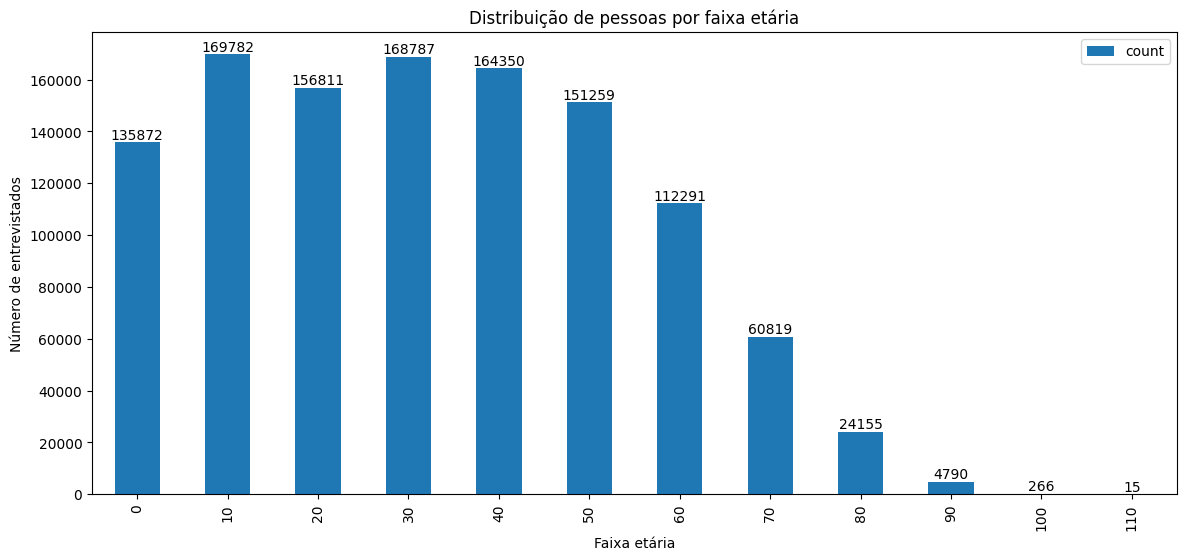

In [ ]:
# Vamos precisar converter o dataframe do spark para o pandas para conseguir visualizar de maneira gráfica

df_idade_pd = df_idade.toPandas()

df_idade_pd = df_idade_pd.sort_values(by='faixa_idade')

ax = df_idade_pd.plot(x='faixa_idade', y='count', kind='bar', figsize=(14,6))
plt.xlabel('Faixa etária')
plt.ylabel('Número de entrevistados')
plt.title('Distribuição de pessoas por faixa etária')
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2,
            i.get_height() + 1,
            f'{int(i.get_height())}',
            ha='center',
            va='bottom',
            rotation=0)

plt.show()

# Características econômicas da sociedade

Para definir as características econômicas da sociedade, iremos trabalhar com as colunas escolaridade, plano_saude, trabalhou e faixa_rendimento.

In [ ]:
df_final.dtypes

[('mes', 'string'),
 ('uf', 'string'),
 ('situacao_domicilio', 'string'),
 ('idade', 'int'),
 ('sexo', 'string'),
 ('escolaridade', 'string'),
 ('febre', 'string'),
 ('tosse', 'string'),
 ('dor_garganta', 'string'),
 ('dificuldade_respirar', 'string'),
 ('plano_saude', 'string'),
 ('trabalhou', 'string'),
 ('faixa_rendimento', 'string'),
 ('dor_cabeca', 'string'),
 ('nausea', 'string'),
 ('nariz_entupido', 'string'),
 ('fadiga', 'string'),
 ('perda_cheiro', 'string'),
 ('dor_muscular', 'string'),
 ('estabelecimento_saude', 'string')]

Aqui vemos que estamos trabalhando apenas com colunas do tipo string.

In [ ]:
df_final.describe('escolaridade', 'plano_saude', 'trabalhou', 'faixa_rendimento').show()

+-------+--------------------+-----------+---------+----------------+
|summary|        escolaridade|plano_saude|trabalhou|faixa_rendimento|
+-------+--------------------+-----------+---------+----------------+
|  count|             1149197|    1149197|   948578|          422735|
|   mean|                NULL|       NULL|     NULL|            NULL|
| stddev|                NULL|       NULL|     NULL|            NULL|
|    min|Fundamental completa|   Ignorado|      Não|         0 - 100|
|    max| Superior incompleto|        Sim|      Sim| Mais de 100.000|
+-------+--------------------+-----------+---------+----------------+



Com as estatísticas básicas, podemos ver que a contagem das colunas escolaridade e plano_saude estão batendo, porém temos dados nulos nas demais colunas.

## Distribuição dos dados em cada coluna

In [ ]:
contagem_esc = df_final.groupBy("escolaridade").count()

contagem_esc = contagem_esc.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_esc.show()

+--------------------+------+----------+
|        escolaridade| count|percentual|
+--------------------+------+----------+
|Pós-graduação, me...| 30290|     2.64%|
| Superior incompleto| 59678|     5.19%|
|Fundamental incom...|387986|    33.76%|
|      Médio completo|256040|    22.28%|
|   Superior completo|107441|     9.35%|
|       Sem instrução|124035|    10.79%|
|    Médio incompleto|107635|     9.37%|
|Fundamental completa| 76092|     6.62%|
+--------------------+------+----------+



In [ ]:
contagem_plano = df_final.groupBy("plano_saude").count()

contagem_plano = contagem_plano.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_plano.show()

+-----------+------+----------+
|plano_saude| count|percentual|
+-----------+------+----------+
|   Ignorado|  2470|     0.21%|
|        Não|886199|    77.11%|
|        Sim|260528|    22.67%|
+-----------+------+----------+



In [ ]:
contagem_trab = df_final.groupBy("trabalhou").count()

contagem_trab = contagem_trab.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_trab.show()

+---------+------+----------+
|trabalhou| count|percentual|
+---------+------+----------+
|      Não|524316|    45.62%|
|     NULL|200619|    17.46%|
|      Sim|424262|    36.92%|
+---------+------+----------+



In [ ]:
contagem_rend = df_final.groupBy("faixa_rendimento").count()

contagem_rend = contagem_rend.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_rend.show()

+----------------+------+----------+
|faixa_rendimento| count|percentual|
+----------------+------+----------+
|       101 - 300| 14405|     1.25%|
| 10.001 - 50.000|  7720|     0.67%|
|            NULL|726462|    63.21%|
|50.001 - 100.000|    47|     0.00%|
|       301 - 600| 30397|     2.65%|
|         0 - 100|  2848|     0.25%|
|   1.601 - 3.000|103125|     8.97%|
|     801 - 1.600|189736|    16.51%|
|       601 - 800| 16718|     1.45%|
|  3.001 - 10.000| 57729|     5.02%|
| Mais de 100.000|    10|     0.00%|
+----------------+------+----------+



# Características clínicas dos sintomas

Para definir as características clínicas dos sintomas, iremos trabalhar com as colunas febre, tosse, dor_garganta, dificuldade_respirar, dor_cabeca, nausea, nariz_entupido, fadiga, perda_cheiro, dor_muscular e estabelecimento_saude.

In [ ]:
df_final.dtypes

[('mes', 'string'),
 ('uf', 'string'),
 ('situacao_domicilio', 'string'),
 ('idade', 'int'),
 ('sexo', 'string'),
 ('escolaridade', 'string'),
 ('febre', 'string'),
 ('tosse', 'string'),
 ('dor_garganta', 'string'),
 ('dificuldade_respirar', 'string'),
 ('plano_saude', 'string'),
 ('trabalhou', 'string'),
 ('faixa_rendimento', 'string'),
 ('dor_cabeca', 'string'),
 ('nausea', 'string'),
 ('nariz_entupido', 'string'),
 ('fadiga', 'string'),
 ('perda_cheiro', 'string'),
 ('dor_muscular', 'string'),
 ('estabelecimento_saude', 'string')]

Aqui vemos que estamos trabalhando apenas com colunas do tipo string.

In [ ]:
df_final.describe('febre', 'tosse', 'dor_garganta', 'dificuldade_respirar', 'dor_cabeca', 'nausea', 'nariz_entupido', 'fadiga', 'perda_cheiro', 'dor_muscular', 'estabelecimento_saude').show()

+-------+--------+--------+------------+--------------------+----------+--------+--------------+--------+------------+------------+---------------------+
|summary|   febre|   tosse|dor_garganta|dificuldade_respirar|dor_cabeca|  nausea|nariz_entupido|  fadiga|perda_cheiro|dor_muscular|estabelecimento_saude|
+-------+--------+--------+------------+--------------------+----------+--------+--------------+--------+------------+------------+---------------------+
|  count| 1149197| 1149197|     1149197|             1149197|   1149197| 1149197|       1149197| 1149197|     1149197|     1149197|                44950|
|   mean|    NULL|    NULL|        NULL|                NULL|      NULL|    NULL|          NULL|    NULL|        NULL|        NULL|                 NULL|
| stddev|    NULL|    NULL|        NULL|                NULL|      NULL|    NULL|          NULL|    NULL|        NULL|        NULL|                 NULL|
|    min|Ignorado|Ignorado|    Ignorado|            Ignorado|  Ignorado|Igno

Com as estatísticas básicas, podemos ver que a contagem de quase todas as colunas estão batendo, menos a estabelecimento_saude.

## Distribuição dos dados em cada coluna

In [ ]:
contagem_febre = df_final.groupBy("febre").count()

contagem_febre = contagem_febre.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_febre.show()

+--------+-------+----------+
|   febre|  count|percentual|
+--------+-------+----------+
|Ignorado|   3513|     0.31%|
|     Não|1136024|    98.85%|
|     Sim|   9020|     0.78%|
|Não sabe|    640|     0.06%|
+--------+-------+----------+



In [ ]:
contagem_tosse = df_final.groupBy("tosse").count()

contagem_tosse = contagem_tosse.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_tosse.show()

+--------+-------+----------+
|   tosse|  count|percentual|
+--------+-------+----------+
|Ignorado|   3549|     0.31%|
|     Não|1129630|    98.30%|
|     Sim|  15373|     1.34%|
|Não sabe|    645|     0.06%|
+--------+-------+----------+



In [ ]:
contagem_gar = df_final.groupBy("dor_garganta").count()

contagem_gar = contagem_gar.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_gar.show()

+------------+-------+----------+
|dor_garganta|  count|percentual|
+------------+-------+----------+
|    Ignorado|   3549|     0.31%|
|         Não|1132408|    98.54%|
|         Sim|  12557|     1.09%|
|    Não sabe|    683|     0.06%|
+------------+-------+----------+



In [ ]:
contagem_resp = df_final.groupBy("dificuldade_respirar").count()

contagem_resp = contagem_resp.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_resp.show()

+--------------------+-------+----------+
|dificuldade_respirar|  count|percentual|
+--------------------+-------+----------+
|            Ignorado|   3552|     0.31%|
|                 Não|1140175|    99.21%|
|                 Sim|   4799|     0.42%|
|            Não sabe|    671|     0.06%|
+--------------------+-------+----------+



In [ ]:
contagem_cab = df_final.groupBy("dor_cabeca").count()

contagem_cab = contagem_cab.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_cab.show()

+----------+-------+----------+
|dor_cabeca|  count|percentual|
+----------+-------+----------+
|  Ignorado|   3550|     0.31%|
|       Não|1125929|    97.98%|
|       Sim|  18960|     1.65%|
|  Não sabe|    758|     0.07%|
+----------+-------+----------+



In [ ]:
contagem_nausea = df_final.groupBy("nausea").count()

contagem_nausea = contagem_nausea.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_nausea.show()

+--------+-------+----------+
|  nausea|  count|percentual|
+--------+-------+----------+
|Ignorado|   3590|     0.31%|
|     Não|1140959|    99.28%|
|     Sim|   3958|     0.34%|
|Não sabe|    690|     0.06%|
+--------+-------+----------+



In [ ]:
contagem_nariz = df_final.groupBy("nariz_entupido").count()

contagem_nariz = contagem_nariz.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_nariz.show()

+--------------+-------+----------+
|nariz_entupido|  count|percentual|
+--------------+-------+----------+
|      Ignorado|   3570|     0.31%|
|           Não|1128818|    98.23%|
|           Sim|  16140|     1.40%|
|      Não sabe|    669|     0.06%|
+--------------+-------+----------+



In [ ]:
contagem_fadiga = df_final.groupBy("fadiga").count()

contagem_fadiga = contagem_fadiga.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_fadiga.show()

+--------+-------+----------+
|  fadiga|  count|percentual|
+--------+-------+----------+
|Ignorado|   3577|     0.31%|
|     Não|1136724|    98.91%|
|     Sim|   8208|     0.71%|
|Não sabe|    688|     0.06%|
+--------+-------+----------+



In [ ]:
contagem_cheiro = df_final.groupBy("perda_cheiro").count()

contagem_cheiro = contagem_cheiro.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_cheiro.show()

+------------+-------+----------+
|perda_cheiro|  count|percentual|
+------------+-------+----------+
|    Ignorado|   4642|     0.40%|
|         Não|1139426|    99.15%|
|         Sim|   4413|     0.38%|
|    Não sabe|    716|     0.06%|
+------------+-------+----------+



In [ ]:
contagem_musc = df_final.groupBy("dor_muscular").count()

contagem_musc = contagem_musc.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_musc.show()

+------------+-------+----------+
|dor_muscular|  count|percentual|
+------------+-------+----------+
|    Ignorado|   4542|     0.40%|
|         Não|1133070|    98.60%|
|         Sim|  10883|     0.95%|
|    Não sabe|    702|     0.06%|
+------------+-------+----------+



In [ ]:
contagem_saude = df_final.groupBy("estabelecimento_saude").count()

contagem_saude = contagem_saude.withColumn("percentual", F.format_string("%.2f%%", (F.col("count") / total_linhas) * 100))

contagem_saude.show()

+---------------------+-------+----------+
|estabelecimento_saude|  count|percentual|
+---------------------+-------+----------+
|             Ignorado|     13|     0.00%|
|                  Não|  33141|     2.88%|
|                 NULL|1104247|    96.09%|
|                  Sim|  11796|     1.03%|
+---------------------+-------+----------+

